### Libraries and definitions

In [1]:
%matplotlib inline
import shutil, os, sys
from prody import *
from pylab import *
from matplotlib import pyplot as plt
import numpy as np
import mrcfile
from scipy.ndimage import gaussian_filter

In [2]:
!source activate eman-env

++++ LDFLAGS=
++++ LDFLAGS=
++++ CXXFLAGS=
++++ set +x


In [3]:
chimera_bin='/Applications/Chimera.app/Contents/MacOS/chimera'

# LocalResDomains with difference map
Here we segment the local resolution map into domains.

see following [link](http://topf-group.ismb.lon.ac.uk/chimera_diffmap.py) for source of script.

See following [link](http://plato.cgl.ucsf.edu/pipermail/chimera-users/2014-January/009553.html) for some info about how to proceed. The Segger python tools can be found here: `/Applications/Chimera.app/Contents/Resources/share/Segger`.

It is hosted at [SLAC](https://cryoem.slac.stanford.edu/ncmi/resources/software/segger)

In [5]:
input_dir = '/Users/fpoitevi/gdrive/cryoEM/Projects/20181005-rib-TEM4/processing/LocalRes/bin2_of_bin6mb_B'
body_dir  = '/Users/fpoitevi/gdrive/cryoEM/Projects/20181005-rib-TEM4/processing/bodymaker/bin2_of_bin6mb_B/SegOfDiffLRM'
bin_dir   = 'automated_bodies'
# files
keyword='bodies_bin2_of_bin6_mbB_'
mrc2diffpy   = bin_dir+'/mrc2diff.py'
mrc2segpy    = bin_dir+'/mrc2seg.py'
input_mrc    = input_dir+'/relion_locres_filtered.mrc'
output_mrc   = body_dir+'/'+keyword+'diff.mrc'
output_seg   = body_dir+'/'+keyword+'seg.mrc'
output_mask  = body_dir+'/'+keyword
# parameters
std_lo = 1
std_hi = 3
sigma_lopass = 4
presegger_sdLevel  = 3
segger_nsteps   = 4
segger_stepsize = 2
segger_minregionsize = 100
segger_mincontactsize = 5
mask_blur = 2.0
#

In [6]:
data = mrc2data(input_mrc)
# get std of input map
input_std = np.std(data)

### Visualize threshold effect

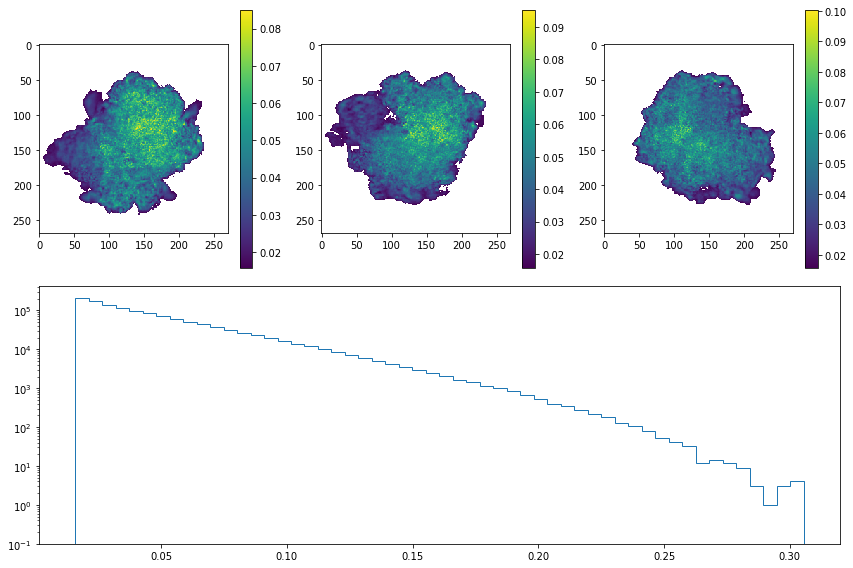

In [44]:
data_thresh = mrc_select(input_mrc, mode='above_value', value=1*input_std)
view_map_xyzproj(data_thresh)

### Visualize binarize

In [45]:
help(data2mask)

Help on function data2mask in module __main__:

data2mask(data, sigma_blur=0.0, threshold=0.1)
    data2mask: set to 1 any non-zero value, blurs, and binarize around threshold



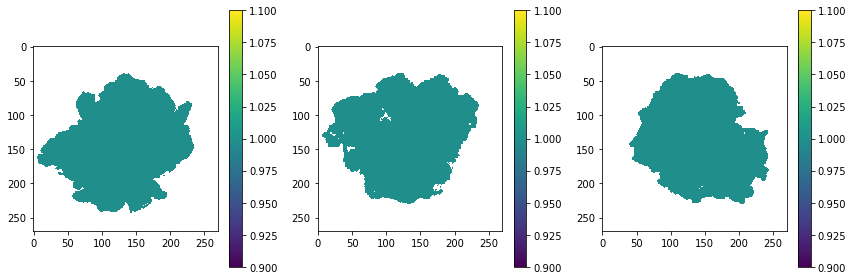

In [62]:
mask = data2mask(data_thresh, sigma_blur=0, threshold=0.1)
view_map_xyzproj(mask,style='simple')

### More fun

In [95]:
data_dry = mrc_select(input_mrc, mode='above_value', value=5*input_std)
mask_dry = data2mask(data_dry, sigma_blur=10, threshold=0.01)
data_fat = mrc_select(input_mrc, mode='above_value', value=1*input_std)
mask_fat = data2mask(data_fat, sigma_blur=2, threshold=0.1)
diff_mask = mask_fat - mask_dry

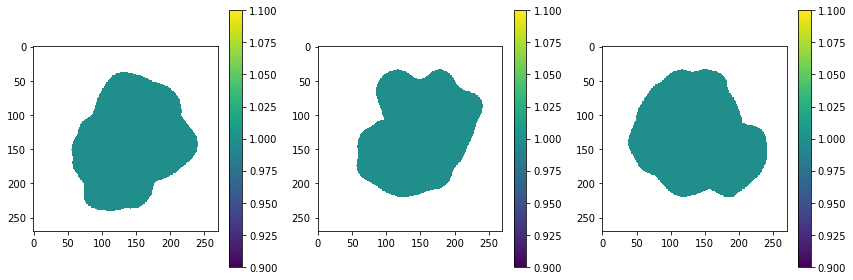

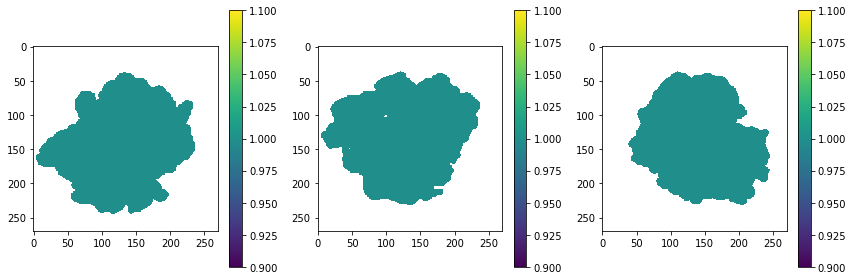

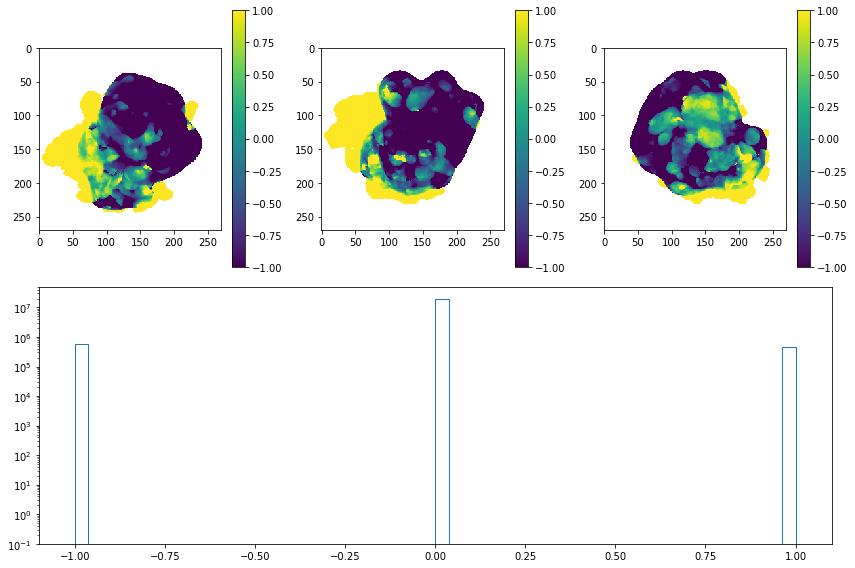

In [96]:
view_map_xyzproj(mask_dry,style='simple')
view_map_xyzproj(mask_fat,style='simple')
view_map_xyzproj(diff_mask)

The idea is to
- blur mask_dry a lot
- blur mask_fat a little
- define the main body as the intersection of both
- define the other bodies as what remains of mask_fat after removing the intersection
- then segment them

In other words:

$B_0 = M_{fat} \cap M_{dry}$

$\bigcup_{i>1}^{K} B_{i} = M_{fat} \setminus B_0 $

In [47]:
data_dry = mrc_select(input_mrc, mode='above_value', value=5*input_std)
mask_dry = data2mask(data_dry, sigma_blur=15, threshold=0.01)
data_fat = mrc_select(input_mrc, mode='above_value', value=1*input_std)
mask_fat = data2mask(data_fat, sigma_blur=1, threshold=0.1)

In [48]:
body0 = np.minimum(mask_dry,mask_fat)
bodyK = mask_fat - body0

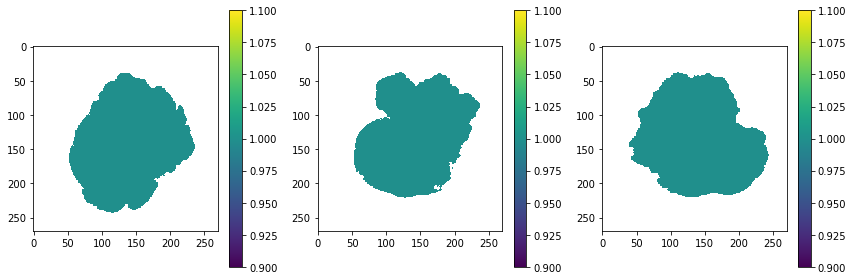

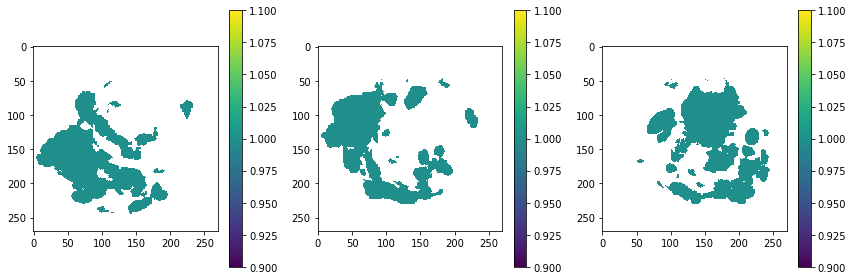

In [49]:
view_map_xyzproj(body0,style='simple')
view_map_xyzproj(bodyK,style='simple')

In [50]:
data2mrc(output_mask+'body_0.mrc',body0,mrc_template=input_mrc)
data2mrc(output_mask+'body_K.mrc',bodyK,mrc_template=input_mrc)

### Segmentation

#### Marker-based method

##### - Watershed segmentation
See [link](https://scipy-lectures.org/packages/scikit-image/index.html#marker-based-methods) on how to do with skimage

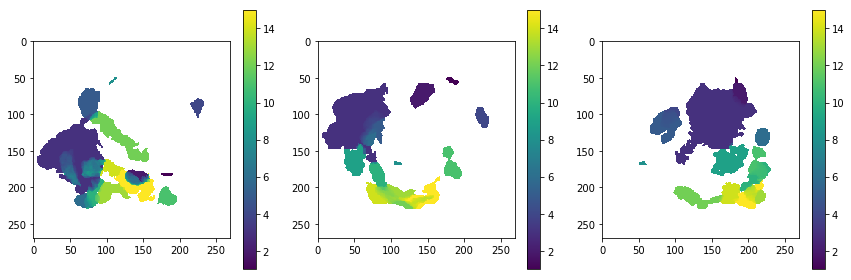

In [52]:
import skimage.morphology as morphology
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from scipy import ndimage
fp=60
distance = ndimage.distance_transform_edt(bodyK)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((fp,fp,fp)), labels=bodyK)
markers = morphology.label(local_maxi)
labels_ws = watershed(-distance, markers, mask=bodyK)
view_map_xyzproj(labels_ws,style='simple')

In [53]:
data2mrc(output_mask+'body_K_watershed_seg.mrc',labels_ws,mrc_template=input_mrc)
# break down: one mask per segment
seg2mask(output_mask+'body_K_watershed_seg.mrc', output_mask+'body_K_watershed', sigma_blur = mask_blur,sort='volume',verbose=True)

/Users/fpoitevi/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


/Users/fpoitevi/gdrive/cryoEM/Projects/20181005-rib-TEM4/processing/bodymaker/bin2_of_bin6mb_B/SegOfDiffLRM/bodies_bin2_of_bin6_mbB_body_K_watershed1.mrc > volume = 542229.0
/Users/fpoitevi/gdrive/cryoEM/Projects/20181005-rib-TEM4/processing/bodymaker/bin2_of_bin6mb_B/SegOfDiffLRM/bodies_bin2_of_bin6_mbB_body_K_watershed2.mrc > volume = 179040.0
/Users/fpoitevi/gdrive/cryoEM/Projects/20181005-rib-TEM4/processing/bodymaker/bin2_of_bin6mb_B/SegOfDiffLRM/bodies_bin2_of_bin6_mbB_body_K_watershed3.mrc > volume = 150456.0
/Users/fpoitevi/gdrive/cryoEM/Projects/20181005-rib-TEM4/processing/bodymaker/bin2_of_bin6mb_B/SegOfDiffLRM/bodies_bin2_of_bin6_mbB_body_K_watershed4.mrc > volume = 149688.0
/Users/fpoitevi/gdrive/cryoEM/Projects/20181005-rib-TEM4/processing/bodymaker/bin2_of_bin6mb_B/SegOfDiffLRM/bodies_bin2_of_bin6_mbB_body_K_watershed5.mrc > volume = 130833.0
/Users/fpoitevi/gdrive/cryoEM/Projects/20181005-rib-TEM4/processing/bodymaker/bin2_of_bin6mb_B/SegOfDiffLRM/bodies_bin2_of_bin6_mb

and [this link](https://mahotas.readthedocs.io/en/latest/distance.html) on how to do it with `mahotas` (quite slow)

In [ ]:
import mahotas
distances = mahotas.stretch(mahotas.distance(bodyK))
Bc = np.ones((9,9,9))
maxima = mahotas.morph.regmax(distances, Bc=Bc)
spots,n_spots = mahotas.label(maxima, Bc=Bc)
surface = (distances.max() - distances)
areas = mahotas.cwatershed(surface, spots)
areas *= bodyK

#### - random-walker segmentation
See [link](https://scipy-lectures.org/packages/scikit-image/index.html#random-walker-segmentation) on how to do it with skimage (pretty slow)

In [ ]:
from skimage import segmentation
markers[~bodyK] = -1
labels_rw = segmentation.random_walker(bodyK, markers)
view_map_xyzproj(labels_ws,style='simple')

#### Histogram-based method

##### - Labelling connected components of a discrete image
See [link](https://scipy-lectures.org/packages/scikit-image/index.html#binary-segmentation-foreground-background) on how to do it with skimage

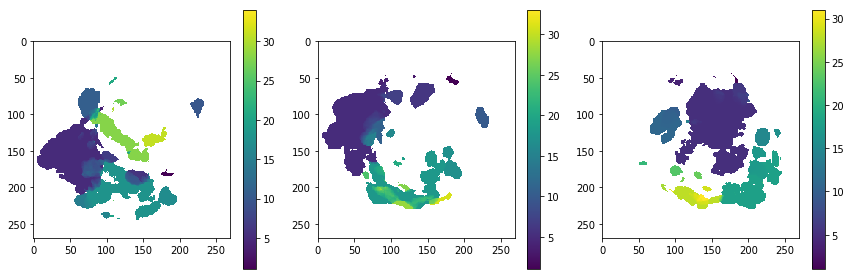

In [51]:
import skimage
from skimage import measure
# we have binarized the map, so we are ready to go.
labels = measure.label(bodyK,neighbors=8,connectivity=1)
view_map_xyzproj(labels,style='simple')

### Older stuff

In [21]:
# get maps at two different thresholds
data_fat =  mrc_select(input_mrc, mode='above_value', value=std_lo*input_std)
data_dry =  mrc_select(input_mrc, mode='above_value', value=std_hi*input_std)
# low-pass filter the difference
data_diff = gaussian_filter(data_fat-data_dry, sigma=sigma_lopass)
# write
data2mrc(output_mrc, data_diff, mrc_template=input_mrc)

In [22]:
# segment
! $chimera_bin --script "$mrc2segpy $output_mrc $output_seg $presegger_sdLevel $segger_nsteps $segger_stepsize $segger_minregionsize $segger_mincontactsize"

In [23]:
# break down: one mask per segment
seg2mask(output_seg, output_mask, sigma_blur = mask_blur)

In [23]:
# manually decide which domain to keep
keep_mask   = np.array([True,False,False,True,False,True])

In [24]:
# copy the ones we keep, and delete old
nkeep = seg2kept(output_seg, output_mask, keep_mask)

keeping  3  domains


In [25]:
# build mask of core domain
mask = data2mask(data_dry, sigma_blur = mask_blur)
data2mrc(output_mask+'kept_0.mrc',mask,mrc_template=input_mrc)

In [26]:
# now apply a gaussian filter to soften the edges
for ikeep in np.arange(nkeep+1):
    mask = mrc2data(output_mask+'kept_'+str(ikeep)+'.mrc')
    mask_soft = data2mask(mask, sigma_blur = mask_blur) #gaussian_filter(mask, mask_blur)
    data2mrc(output_mask+str(ikeep)+'.mrc',mask_soft,mrc_template=output_mask+'kept_'+str(ikeep)+'.mrc')
    os.remove(output_mask+'kept_'+str(ikeep)+'.mrc')

# Toolkit

In [42]:
# routines on manipulation of mrc data

def mrc_stats(mrc_filename, get='std'):
    """ mrcstats
    """
    data = mrc2data(mrc_filename)
    mean = np.mean(data)
    if(get=='mean'):
        value = mean
    elif(get=='std'):
        value = np.std(data-mean)
    elif(get=='min'):
        value = np.min(data)
    elif(get=='max'):
        value = np.max(data)
    elif(get=='sum'):
        value = np.sum(data)
    return value

def mrc_algebra(mrc1,mrc2,mrc_out,operation='add'):
    """mrc_algebra: mrc_out = mrc1 operation mrc2
    """
    data1 = mrc2data(mrc1)
    data2 = mrc2data(mrc2)
    if(operation=='add'):
        data = data1 + data2
    elif(operation=='subtract'):
        data = data1 - data2
    data2mrc(mrc_out,data,mrc_template=mrc1)
        
def mrc_select(mrc_filename, mode='above_value', value=0.):
    """mrc_select
    """
    data = mrc2data(mrc_filename)
    if(mode=='above_value'):
        data_selected = np.where(data >  value, data, 0.0)
    elif(mode=='equal_value'):
        data_selected = np.where(data == value, data, 0.0)
    else:
        data_selected = np.where(data <  value, data, 0.0)
    return data_selected
        
# routines mrc2bla or bla2mrc
    
def mrc2mask(mrc_filename, mask_filename, sigma_blur=0., threshold=0.1):
    """ mrc2mask: set to 1 any non-zero value, blurs, and binarize around threshold
    """
    data = mrc2data(mrc_filename)
    mask = data2mask(data, sigma_blur=sigma_blur, threshold=threshold)
    data2mrc(mask_filename, mask, mrc_template=mrc_filename)

def seg2mask(input_seg, output_key, sigma_blur = 0., threshold=0.1,sort=None,verbose=False):
    """seg2mask
    """
    segments = mrc2data(input_seg)
    domains  = np.unique(segments).astype(int)
    index_order = domains
    if sort is not None:
        if(sort=='volume'):
            volume = []
            if (domains.shape[0] > 1):
                for i in domains:
                    data_domain = mrc_select(input_seg, mode='equal_value', value=i)
                    masked = np.ma.masked_equal(data_domain, 0)
                    volume.append(np.sum(masked))
            index_order = np.argsort(volume)[::-1]
    if (domains.shape[0] > 1):
        for i in domains:
            if(i>0):
                data_domain = mrc_select(input_seg, mode='equal_value', value=index_order[i])
                mask = data2mask(data_domain, sigma_blur=sigma_blur, threshold=threshold)
                data2mrc(output_key+str(i)+'.mrc', mask, mrc_template=input_seg)
                if verbose:
                    print("{0} > volume = {1}".format(output_key+str(i)+'.mrc',volume[index_order[i]]))
                
def seg2kept(input_seg, output_key, keep_mask):
    """seg2kep
    """
    ikeep=0
    segments = mrc2data(input_seg)
    domains  = np.unique(segments).astype(int)
    if (domains.shape[0] > 1):
        for i in domains:
            if(i>0):
                if keep_mask[i-1]:
                    ikeep += 1
                    shutil.copy(output_key+str(i)+'.mrc',output_key+'kept_'+str(ikeep)+'.mrc')
                os.remove(output_key+str(i)+'.mrc')
    print("keeping ",ikeep," domains")
    return ikeep
                
def data2mask(data, sigma_blur=0., threshold=0.1):
    """data2mask: set to 1 any non-zero value, blurs, and binarize around threshold
    """
    mask = np.where(data > 0, 1.0, 0.0)
    if(sigma_blur > 0):
        mask = gaussian_filter(mask, sigma_blur)
        mask = np.where(mask > threshold, 1.0 , 0.0 ) #.astype(np.int8)
    return mask.astype(np.int8)
    
def mrc2data(mrc_filename):
    """ mrc2data
    """
    mrc  = mrcfile.open(mrc_filename, mode='r+')
    data = mrc.data
    mrc.close()
    return data

def data2mrc(mrc_filename,data,mrc_template=None):
    """ data2mrc
    """
    if mrc_template is None:
        print("Please provide a .mrc template to update data from")
    else:
        shutil.copy(mrc_template, mrc_filename)
        mrc = mrcfile.open(mrc_filename, mode='r+')
        mrc.data[:] = data
        mrc.close()
        
def view_map_xyzproj(data,style=None):
    masked = np.ma.masked_equal(data, 0)
    N = data.shape[0]*data.shape[1]*data.shape[2]
    K = int(data.shape[0]/5)
    if style is None:
        fig = plt.figure(figsize=(12,8))
    else:
        fig = plt.figure(figsize=(12,4))
    if style is None:
        plt.subplot(231)
    else:
        plt.subplot(131)
    plt.imshow(np.mean(masked,axis=0))
    plt.colorbar()
    if style is None:
        plt.subplot(232)
    else:
        plt.subplot(132)
    plt.imshow(np.mean(masked,axis=1))
    plt.colorbar()
    if style is None:
        plt.subplot(233)
    else:
        plt.subplot(133)
    plt.imshow(np.mean(masked,axis=2))
    plt.colorbar()
    if style is None:
        plt.subplot(212)
        plt.hist(masked.reshape(N),bins=K,log=True,histtype='step')
    plt.tight_layout()

In [35]:
disordered = np.array([1,2,0])
index_order = np.argsort(disordered)
print(disordered, disordered[index_order])

[1 2 0] [0 1 2]
